<a href="https://colab.research.google.com/github/daiweiworking/BenchmarkDeepLearning/blob/master/Adversarial_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Advisorial Attacks: MNIST datasets

The reference 1 is great tutorial, but I fixed some codes issues.


Reference:
[1] https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=QMMqmdiYMkvi


In [21]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

train_idx = mnist_train.targets <= 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

test_idx = mnist_test.targets <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [4]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.005843	0.015825	0.000946	0.003009
0.001500	0.005412	0.000473	0.002444
0.001184	0.004382	0.000946	0.002326
0.001026	0.003839	0.000946	0.002264
0.000790	0.003377	0.000473	0.002308
0.000790	0.003255	0.000946	0.002033
0.000947	0.003038	0.000946	0.001981
0.000790	0.002782	0.000473	0.002028
0.000711	0.002624	0.000946	0.001893
0.000869	0.002565	0.000946	0.001873


Text(0.5, 1.0, 'True Label: 0')

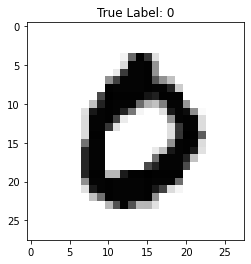

In [25]:
import matplotlib.pyplot as plt
X_test = (test_loader.dataset.data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.targets
yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 0)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx][0].item()))

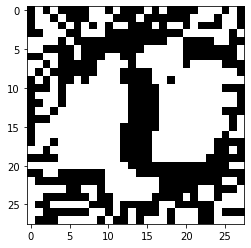

In [33]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [36]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.8070921985815603, 3.3294540240691344)


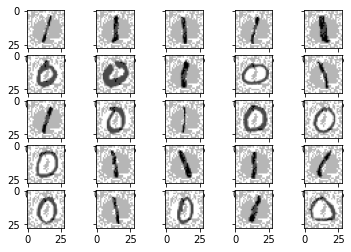

In [73]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

In [86]:
# do a single pass over the data
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [87]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.153494	0.381419	0.061466	0.201634
0.072878	0.223388	0.055792	0.176244
0.063245	0.197693	0.051064	0.166049
0.057560	0.184324	0.038298	0.140848
0.053296	0.174741	0.043972	0.156614
0.050138	0.168280	0.034515	0.126949
0.048006	0.163036	0.037825	0.131708
0.045874	0.158223	0.036879	0.129688
0.044295	0.154681	0.028842	0.118193
0.042479	0.151661	0.028369	0.118260
0.041690	0.149249	0.029314	0.116852
0.040584	0.147176	0.027896	0.112164
0.039637	0.145102	0.027423	0.110427
0.038295	0.143317	0.026950	0.105494
0.037347	0.141707	0.027423	0.109368
0.036715	0.140518	0.027423	0.112376
0.036478	0.139097	0.026005	0.105278
0.035610	0.138075	0.026478	0.108083
0.035136	0.137213	0.024113	0.100344
0.034347	0.136304	0.025059	0.103999


In [88]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.006080	0.015255	0.003783	0.008251


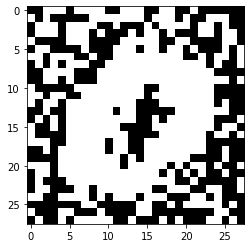

In [92]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")